# Tree-informed optimal transport of single-cell and spatial transcriptomics
Here we generate fake data consisting of paired spatial and single-cell gene expression data. We use Cassiopeia to generate a phylogenetic tree of single-cells and place them in 2D space, and from that we generate single-cell and spot-based gene expression. We then apply various approaches to map the single-cell data to spots.

In [590]:
import anndata
import cassiopeia as cas
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
import squidpy as sq

import importlib
import os

file_path = os.path.join(os.getcwd(), "../src/", "space_simulator.py")
spec = importlib.util.spec_from_file_location("space_simulator", file_path)
space_simulator = importlib.util.module_from_spec(spec)
spec.loader.exec_module(space_simulator)

file_path = os.path.join(os.getcwd(), "../src/", "expression_simulator.py")
spec = importlib.util.spec_from_file_location("expression_simulator", file_path)
expression_simulator = importlib.util.module_from_spec(spec)
spec.loader.exec_module(expression_simulator)

file_path = os.path.join(os.getcwd(), "../src/", "visium_simulator.py")
spec = importlib.util.spec_from_file_location("visium_simulator", file_path)
visium_simulator = importlib.util.module_from_spec(spec)
spec.loader.exec_module(visium_simulator)

file_path = os.path.join(os.getcwd(), "../src/", "mappers.py")
spec = importlib.util.spec_from_file_location("mappers", file_path)
mappers = importlib.util.module_from_spec(spec)
spec.loader.exec_module(mappers)

file_path = os.path.join(os.getcwd(), "../src/", "utils.py")
spec = importlib.util.spec_from_file_location("utils", file_path)
utils = importlib.util.module_from_spec(spec)
spec.loader.exec_module(utils)

file_path = os.path.join(os.getcwd(), "../src/", "spotr.py")
spec = importlib.util.spec_from_file_location("spotr", file_path)
spotr = importlib.util.module_from_spec(spec)
spec.loader.exec_module(spotr)

## Generate cell lineage tree and spatial locations

In [166]:
# define lineage tracing data parameters
number_of_cassettes = 39
size_of_cassette = 1

# Specify the mutation proportion
mutation_proportion = 0.5
get_mutation_rate= lambda depth: -np.log2(1-mutation_proportion)/depth

number_of_states = 100
state_generating_distribution = lambda: np.random.exponential(1e-5)

# Specify the dropout proportions. Note that the heritable missing data proportion will be
# total_dropout_proportion - stochastic_proportion
total_dropout_proportion = 0.0
stochastic_proportion = 0.0
heritable_proportion = total_dropout_proportion - stochastic_proportion

get_heritable_rate = lambda depth: -np.log2(1-heritable_proportion)/depth

In [167]:
tree_simulator = lambda num_extant: cas.sim.BirthDeathFitnessSimulator(
    birth_waiting_distribution = lambda scale: np.random.lognormal(mean = np.log(scale),sigma = .5),
    initial_birth_scale = 1,
    death_waiting_distribution = lambda: np.random.uniform(0,4),
    mutation_distribution = lambda: 1,
    fitness_distribution = lambda: np.random.normal(0, .25),
    fitness_base = 1,
    num_extant = num_extant)

lt_simulator = lambda depth: cas.simulator.Cas9LineageTracingDataSimulator(
    number_of_cassettes = number_of_cassettes,
    size_of_cassette = size_of_cassette,
    mutation_rate = get_mutation_rate(depth),
    number_of_states=number_of_states,
    state_generating_distribution=state_generating_distribution,
    heritable_silencing_rate=get_heritable_rate(depth),
    stochastic_silencing_rate=stochastic_proportion,
    collapse_sites_on_cassette=True)

spatial_simulator = space_simulator.BrownianSpatialDataSimulator(2, 1.)

In [271]:
np.random.seed(1234678)

simulated_tree = tree_simulator(400).simulate_tree()
lt_simulator(simulated_tree.get_mean_depth_of_tree()).overlay_data(simulated_tree)
# simulated_tree = cas.sim.UniformLeafSubsampler(ratio = .1).subsample_leaves(simulated_tree)
simulated_tree.collapse_unifurcations()

In [272]:
import ete3
phylotree = ete3.Tree(simulated_tree.get_newick())
spatial_simulator.make_leaf_cov_matrix(phylotree)

In [273]:
spatial_simulator.make_symmetric_displacement_means(phylotree, radius=10., theta=np.pi/4)

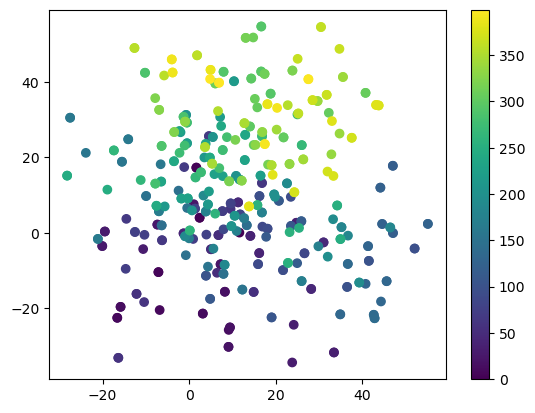

In [274]:
plt.scatter(spatial_simulator.location_means['x'], spatial_simulator.location_means['y'], c=np.arange(spatial_simulator.location_means.shape[0]))
plt.colorbar()

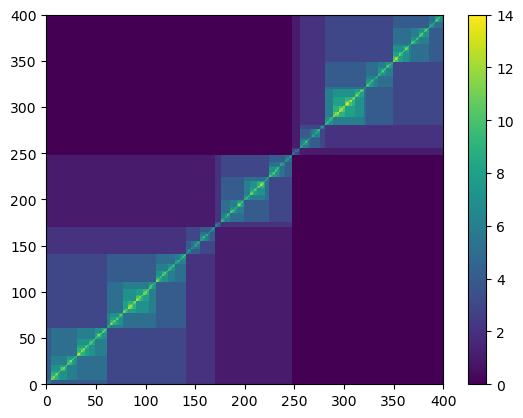

In [275]:
plt.pcolormesh(spatial_simulator.leaf_cov_matrix)
plt.colorbar()
plt.show()

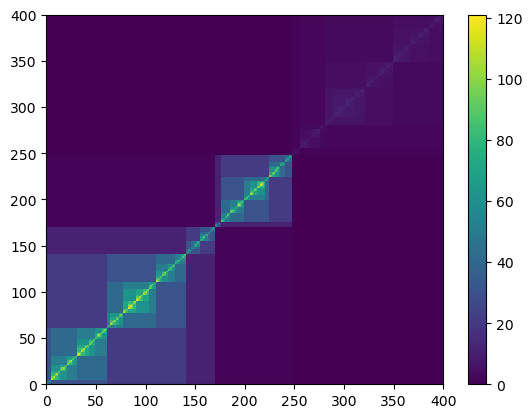

In [276]:
clade = simulated_tree.leaves_in_subtree(simulated_tree.children(simulated_tree.root)[0])
rate = 10.
S, _ = spatial_simulator.rescale_clade(clade, rate)
plt.pcolormesh(S)
plt.colorbar()
plt.show()

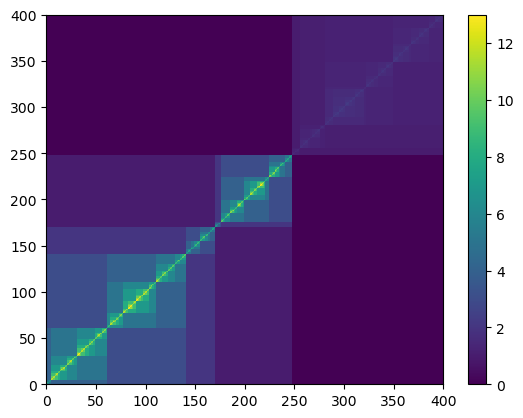

In [277]:
clade = simulated_tree.leaves_in_subtree(simulated_tree.children(simulated_tree.root)[1])
rate = .1
S, _ = spatial_simulator.rescale_clade(clade, rate)
plt.pcolormesh(S)
plt.colorbar()
plt.show()

In [278]:
clades = [simulated_tree.leaves_in_subtree(simulated_tree.children(simulated_tree.root)[0]),
        simulated_tree.leaves_in_subtree(simulated_tree.children(simulated_tree.root)[1])]
rates = [.1, .1]
spatial_simulator.overlay_data(simulated_tree, brownian_motion=True, lambda_brownian=1., clades=clades, rates=rates)

In [279]:
top_clades = simulated_tree.children(simulated_tree.root)
subclades = []
subsubclades = []
for i, clade in enumerate(top_clades):
    leaves = simulated_tree.leaves_in_subtree(clade)
    for j, subclade in enumerate(simulated_tree.children(clade)):
        subclade_leaves = simulated_tree.leaves_in_subtree(subclade)
        subclades.append(subclade_leaves)
        for k, subsubclade in enumerate(simulated_tree.children(subclade)):
            subsubclade_leaves = simulated_tree.leaves_in_subtree(subsubclade)
            subsubclades.append(subsubclade_leaves)

In [280]:
len(subsubclades)

8

In [281]:
spatial_simulator.overlay_data(simulated_tree, brownian_motion=True, lambda_brownian=1., clades=subsubclades, rates=[.1]*len(subsubclades))

In [282]:
# # relabel nodes
# node_map = {l: f'cell{l}' for l in simulated_tree.leaves}
# simulated_tree.relabel_nodes(node_map)
# simulated_tree.character_matrix.index = [f'cell{l}' for l in simulated_tree.character_matrix.index]
# simulated_tree.cell_meta.index = simulated_tree.cell_meta.index.map(node_map)

In [283]:
simulated_adata = anndata.AnnData(obs=pd.DataFrame(index=simulated_tree.leaves))
simulated_adata.obs['library_id'] = 'simulated_puck'

simulated_adata.obsm['spatial'] = simulated_tree.cell_meta[['spatial_0', 'spatial_1']].to_numpy()

/Users/pedroferreira/projects/tumorot/phylospatial_mapping/notebooks/../src/utils.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  adata.obs.loc[tree.leaves, 'Selection'] = "False"
/Users/pedroferreira/miniconda3/envs/phylospatial/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/Users/pedroferreira/miniconda3/envs/phylospatial/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/Users/pedroferreira/miniconda3/envs/phylospatial/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Paramet

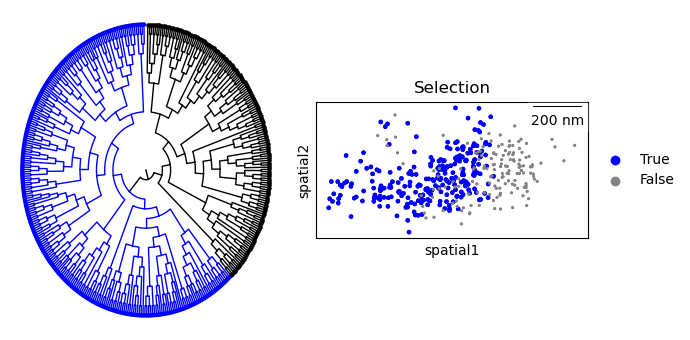

/Users/pedroferreira/projects/tumorot/phylospatial_mapping/notebooks/../src/utils.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  adata.obs.loc[tree.leaves, 'Selection'] = "False"
/Users/pedroferreira/miniconda3/envs/phylospatial/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/Users/pedroferreira/miniconda3/envs/phylospatial/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/Users/pedroferreira/miniconda3/envs/phylospatial/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Paramet

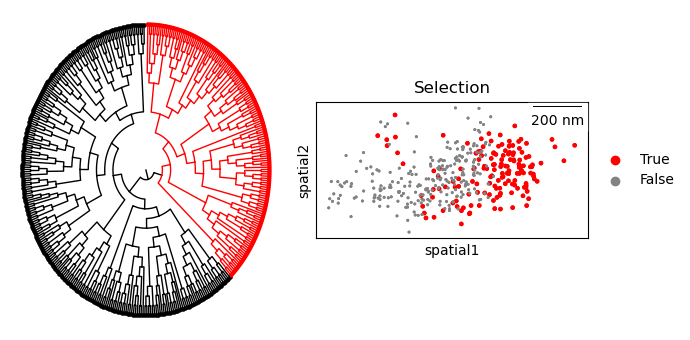

In [284]:
node = simulated_tree.root

# find three largest subclades
sizes = np.array([len(simulated_tree.leaves_in_subtree(child)) for child in simulated_tree.children(node)])
iid = np.argsort(-sizes)[:3]

colors = ['blue', 'red', '#E69F00', '#D34818']
clade_to_colors = {}
for _iter, child in zip(range(3), np.array(simulated_tree.children(node))[iid]):
    clade_to_colors[child] = colors[_iter]
    utils.plot_selection(simulated_tree, simulated_adata, child, colors[_iter])

## Simulate single-cell gene expression profiles
Using a trait model on the tree and tree-indepedent spatial effects  

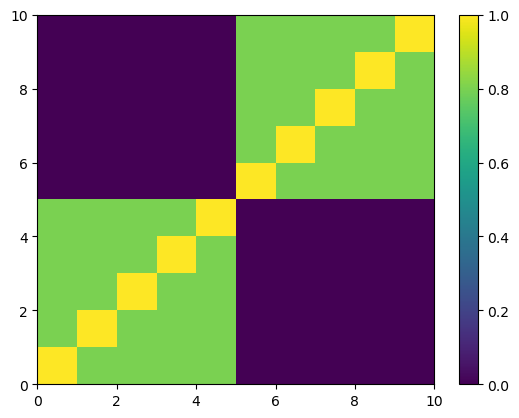

In [285]:
# Brownian Motion model on the tree
n_genes = 10

# Create two blocks of highly correlated genes (block diagonal covariance)
block_size = n_genes // 2
block1 = np.ones((block_size, block_size)) * 0.8 + np.eye(block_size) * 0.2 
block2 = np.ones((n_genes - block_size, n_genes - block_size)) * 0.8 + np.eye(n_genes - block_size) * 0.2
trait_covariances = np.zeros((n_genes, n_genes))
trait_covariances[:block_size, :block_size] = block1
trait_covariances[block_size:, block_size:] = block2
trait_covariances = trait_covariances / 1.

trait_covariances = pd.DataFrame(trait_covariances, index=["G" + str(i) for i in range(n_genes)], columns=["G" + str(i) for i in range(n_genes)])
plt.pcolormesh(trait_covariances)
plt.colorbar()
plt.show()

In [441]:
# Traits as gene programs
n_genes = 10
n_traits = 5
# Each row is a gene program (signature), each column is a gene
# 1 indicates the gene is active in that program, 0 otherwise
np.random.seed(0)
trait_signatures = np.zeros((n_traits, n_genes))
# Make non-overlapping gene programs: each gene belongs to only one program
genes = np.arange(n_genes)
# np.random.shuffle(genes)
split_genes = np.array_split(genes, K)
for k, gene_indices in enumerate(split_genes):
    trait_signatures[k, gene_indices] = 1

trait_signatures = pd.DataFrame(trait_signatures, index=["T" + str(i) for i in range(n_traits)], columns=["G" + str(i) for i in range(n_genes)])
trait_signatures


G0   G1   G2   G3   G4   G5   G6   G7   G8   G9
T0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
T1  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
T2  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0
T3  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0
T4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0

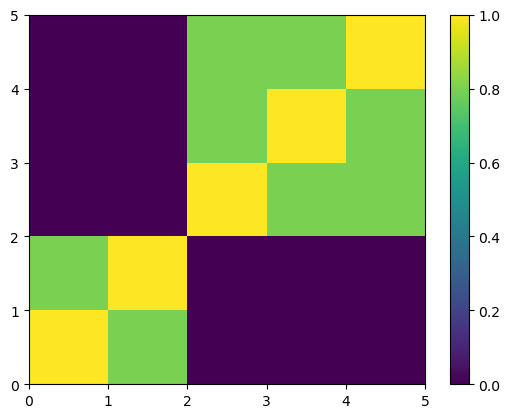

In [413]:
# Brownian Motion model on the tree

# Create two blocks of highly correlated genes (block diagonal covariance)
block_size = n_traits // 2
block1 = np.ones((block_size, block_size)) * 0.8 + np.eye(block_size) * 0.2 
block2 = np.ones((n_traits - block_size, n_traits - block_size)) * 0.8 + np.eye(n_traits - block_size) * 0.2
trait_covariances = np.zeros((n_traits, n_traits))
trait_covariances[:block_size, :block_size] = block1
trait_covariances[block_size:, block_size:] = block2
trait_covariances = trait_covariances / 1.

trait_covariances = pd.DataFrame(trait_covariances, index=["T" + str(i) for i in range(n_traits)], columns=["T" + str(i) for i in range(n_traits)])
plt.pcolormesh(trait_covariances)
plt.colorbar()
plt.show()

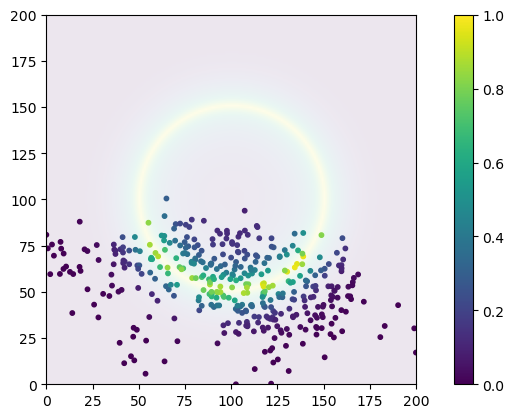

In [408]:
# A continuous spatial effect
spatial_activation = visium_simulator.prior(200, visium_simulator.circ_equation, decay_factor=.001, radius=50, center_x=100, center_y=100)
gene_program = np.zeros((n_genes,))
gene_program[np.random.choice(n_genes, size=5)] = 1. # activate these genes


x = simulated_adata.obsm['spatial'][:, 0]
y = simulated_adata.obsm['spatial'][:, 1]

# Map scatter points to heatmap indices
nx, ny = spatial_activation.shape
xi = (x / 1 * (nx - 1)).astype(int)
yi = (y / 1 * (ny - 1)).astype(int)
# Get heatmap values for each point
cvals = spatial_activation[yi, xi]
# Scatter colored by heatmap values
sc = plt.scatter(x * 200, y * 200, c=cvals, cmap="viridis", s=10, vmax=1, vmin=0)
plt.colorbar()
# Show the heatmap in the background too
plt.imshow(
    spatial_activation,
    extent=[0, 200, 0, 200],
    origin="lower",
    cmap="viridis",
    alpha=0.1
)
plt.axis('square')

plt.show()

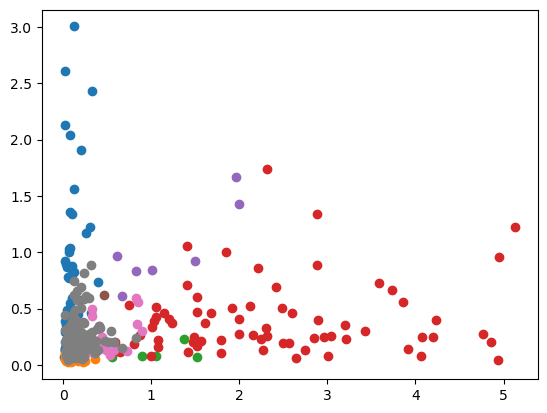

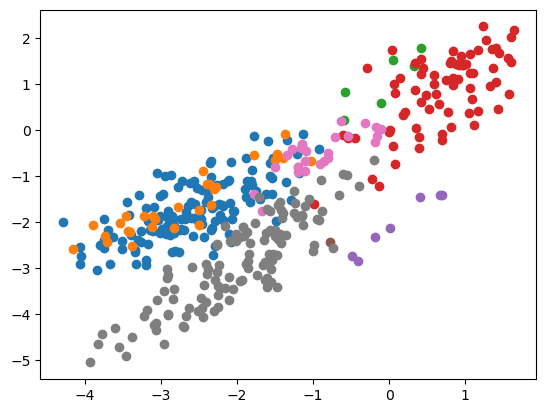

In [443]:
# Generate single-cell expression profiles
clades = [simulated_tree.leaves_in_subtree(simulated_tree.children(simulated_tree.root)[0]),
        simulated_tree.leaves_in_subtree(simulated_tree.children(simulated_tree.root)[1])]
rates = [.1, .1]

ex_simulator = expression_simulator.ExpressionSimulator(trait_covariances, trait_signatures, spatial_activation, gene_program)
ex_simulator.overlay_data(simulated_tree, alpha=1.0, clades=subsubclades, rates=[.1]*len(subsubclades)) # 0: fully external factors, 1: fully tree
expression = simulated_tree.cell_meta[[f'G{i}' for i in range(ex_simulator.n_genes)]]#.to_numpy()
trait_activations = simulated_tree.cell_meta[[f'T{i}' for i in range(ex_simulator.n_traits)]]
for subsubclade in subsubclades:
    plt.scatter(expression.loc[subsubclade]['G0'], expression.loc[subsubclade]['G5'])
plt.show()

for subsubclade in subsubclades:
    plt.scatter(trait_activations.loc[subsubclade]['T0'], trait_activations.loc[subsubclade]['T1'])
plt.show()

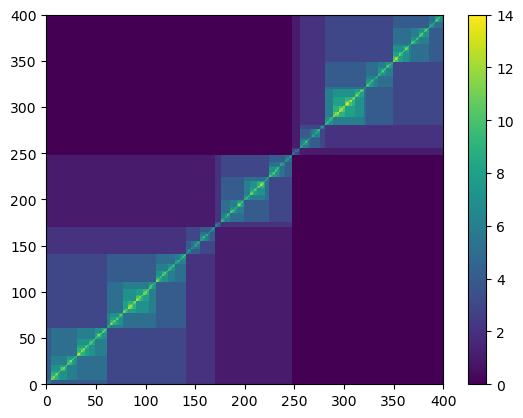

In [299]:
plt.pcolormesh(ex_simulator.leaf_cov_matrix)
plt.colorbar()
plt.show()

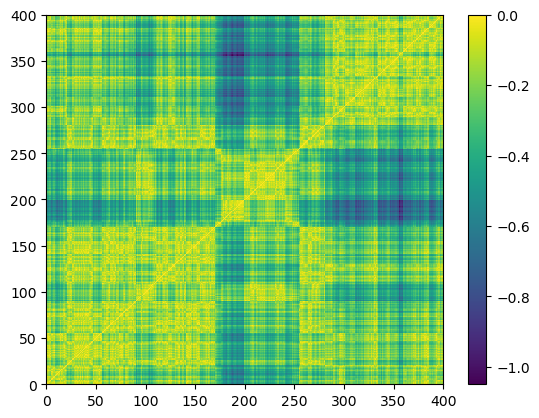

In [300]:
spatial_distance_matrix = squareform(-pdist(simulated_adata[ex_simulator.leaf_names].obsm['spatial'], metric='euclidean'))
plt.pcolormesh(spatial_distance_matrix)
plt.colorbar()
plt.show()

In [301]:
# self = ex_simulator
# leaf_spatial_effects = pd.DataFrame(index=self.leaf_names, columns=self.gene_names)
# for leaf in self.leaf_names:
#     x, y = simulated_tree.cell_meta.loc[leaf, ['spatial_0', 'spatial_1']]
#     x = int(x * (self.spatial_map.shape[0] - 1))
#     y = int(y * (self.spatial_map.shape[1] - 1))
#     leaf_spatial_effects.loc[leaf] = self.spatial_map[x, y] * self.spatial_program
# leaf_spatial_effects = leaf_spatial_effects.astype(float)    
# spatial_effect_distances = squareform(-pdist(leaf_spatial_effects, metric='euclidean'))
# plt.pcolormesh(spatial_effect_distances)
# plt.colorbar()
# plt.show()

In [302]:
# self.spatial_program

In [303]:
# alphas = [0.0, 0.5, 1.0]

# for alpha in alphas:
#     dists = []
#     for i in range(5):
#         ex = ex_simulator.sample_combined_expression(simulated_tree, alpha)
#         ex = ex.astype(float)
#         dists.append(squareform(-pdist(ex, metric='euclidean')))
#     avg_dist = sum(dists) / len(dists)

#     plt.pcolormesh(avg_dist)
#     plt.title(f'Average similarity with alpha = {alpha}')
#     plt.colorbar()
#     plt.show()

## Single-cell RNA-sequencing data simulation

In [451]:
# Simulate single-cell gene expression data
ss_cell_library_sizes = np.random.poisson(1000, size=ex_simulator.n_leaves) * 0 + 1
ss_gene_sizes = np.random.poisson(100, size=ex_simulator.n_genes) * 0 + 1
ss_transcriptomes = np.random.normal(expression, .1)#np.random.poisson(np.exp(expression) * ss_cell_library_sizes[:, None] * ss_gene_sizes[None, :])
ss_simulated_adata = anndata.AnnData(pd.DataFrame(ss_transcriptomes, index=expression.index, columns=expression.columns))
ss_simulated_adata.raw = ss_simulated_adata.copy()
ss_simulated_adata.obs['library_id'] = 'simulated_puck'
ss_simulated_adata.obsm['spatial'] = simulated_tree.cell_meta[['spatial_0', 'spatial_1']].to_numpy()
for trait in ex_simulator.trait_names:
    ss_simulated_adata.obs[trait] = np.exp(trait_activations[trait])


In [453]:
# Top clades
top_clades = simulated_tree.children(simulated_tree.root)
for i, clade in enumerate(top_clades):
    leaves = simulated_tree.leaves_in_subtree(clade)
    ss_simulated_adata.obs.loc[leaves, 'clade_level0'] = 'clade' + str(clade)
    for j, subclade in enumerate(simulated_tree.children(clade)):
        subclade_leaves = simulated_tree.leaves_in_subtree(subclade)
        ss_simulated_adata.obs.loc[subclade_leaves, 'clade_level1'] = 'clade' + str(subclade)     
        for k, subsubclade in enumerate(simulated_tree.children(subclade)):
            subsubclade_leaves = simulated_tree.leaves_in_subtree(subsubclade)
            ss_simulated_adata.obs.loc[subsubclade_leaves, 'clade_level2'] = 'clade' + str(subsubclade)       

/Users/pedroferreira/miniconda3/envs/phylospatial/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/Users/pedroferreira/miniconda3/envs/phylospatial/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/Users/pedroferreira/miniconda3/envs/phylospatial/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


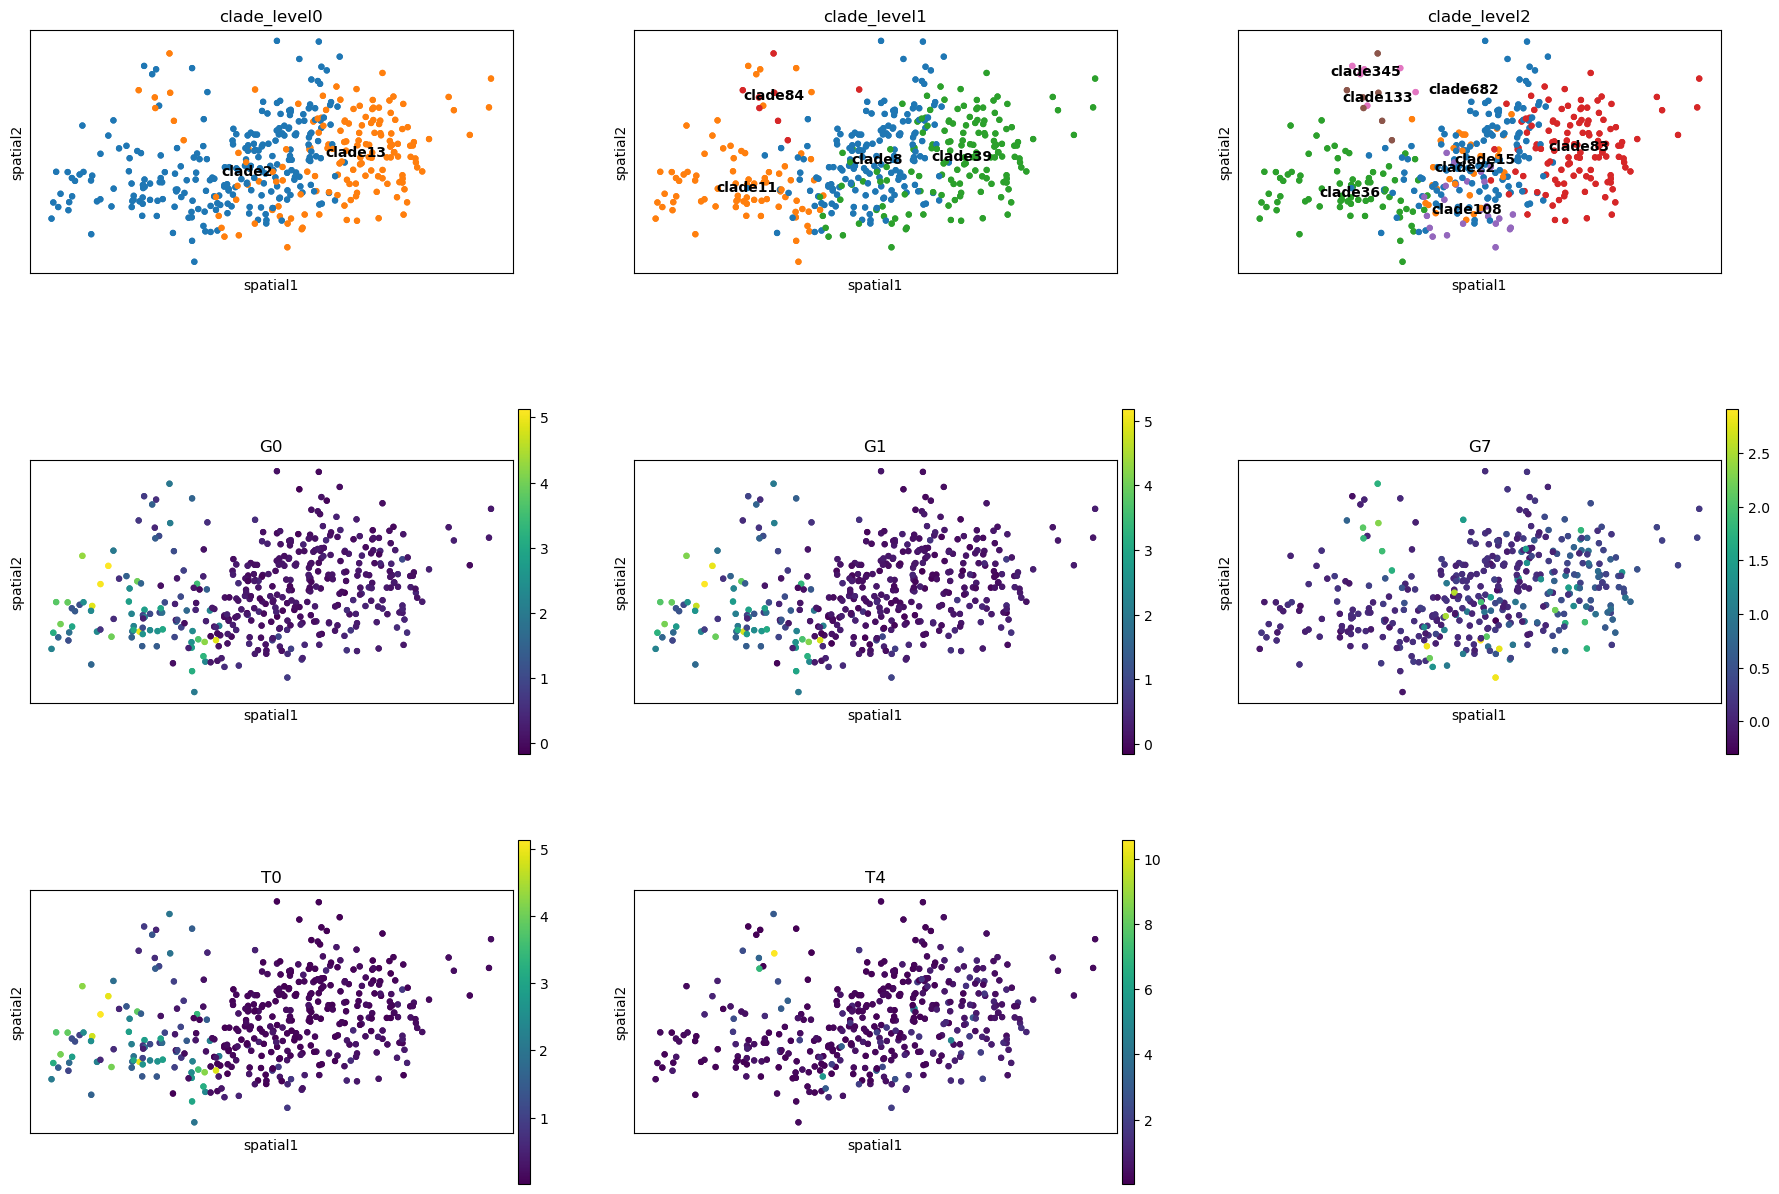

In [454]:
sq.pl.spatial_scatter(ss_simulated_adata, color=['clade_level0', 'clade_level1', 'clade_level2', 'G0', 'G1', 'G7', 'T0', 'T4'], library_id='puck1',
                    size=50, shape=None, legend_loc='on data', ncols=3)

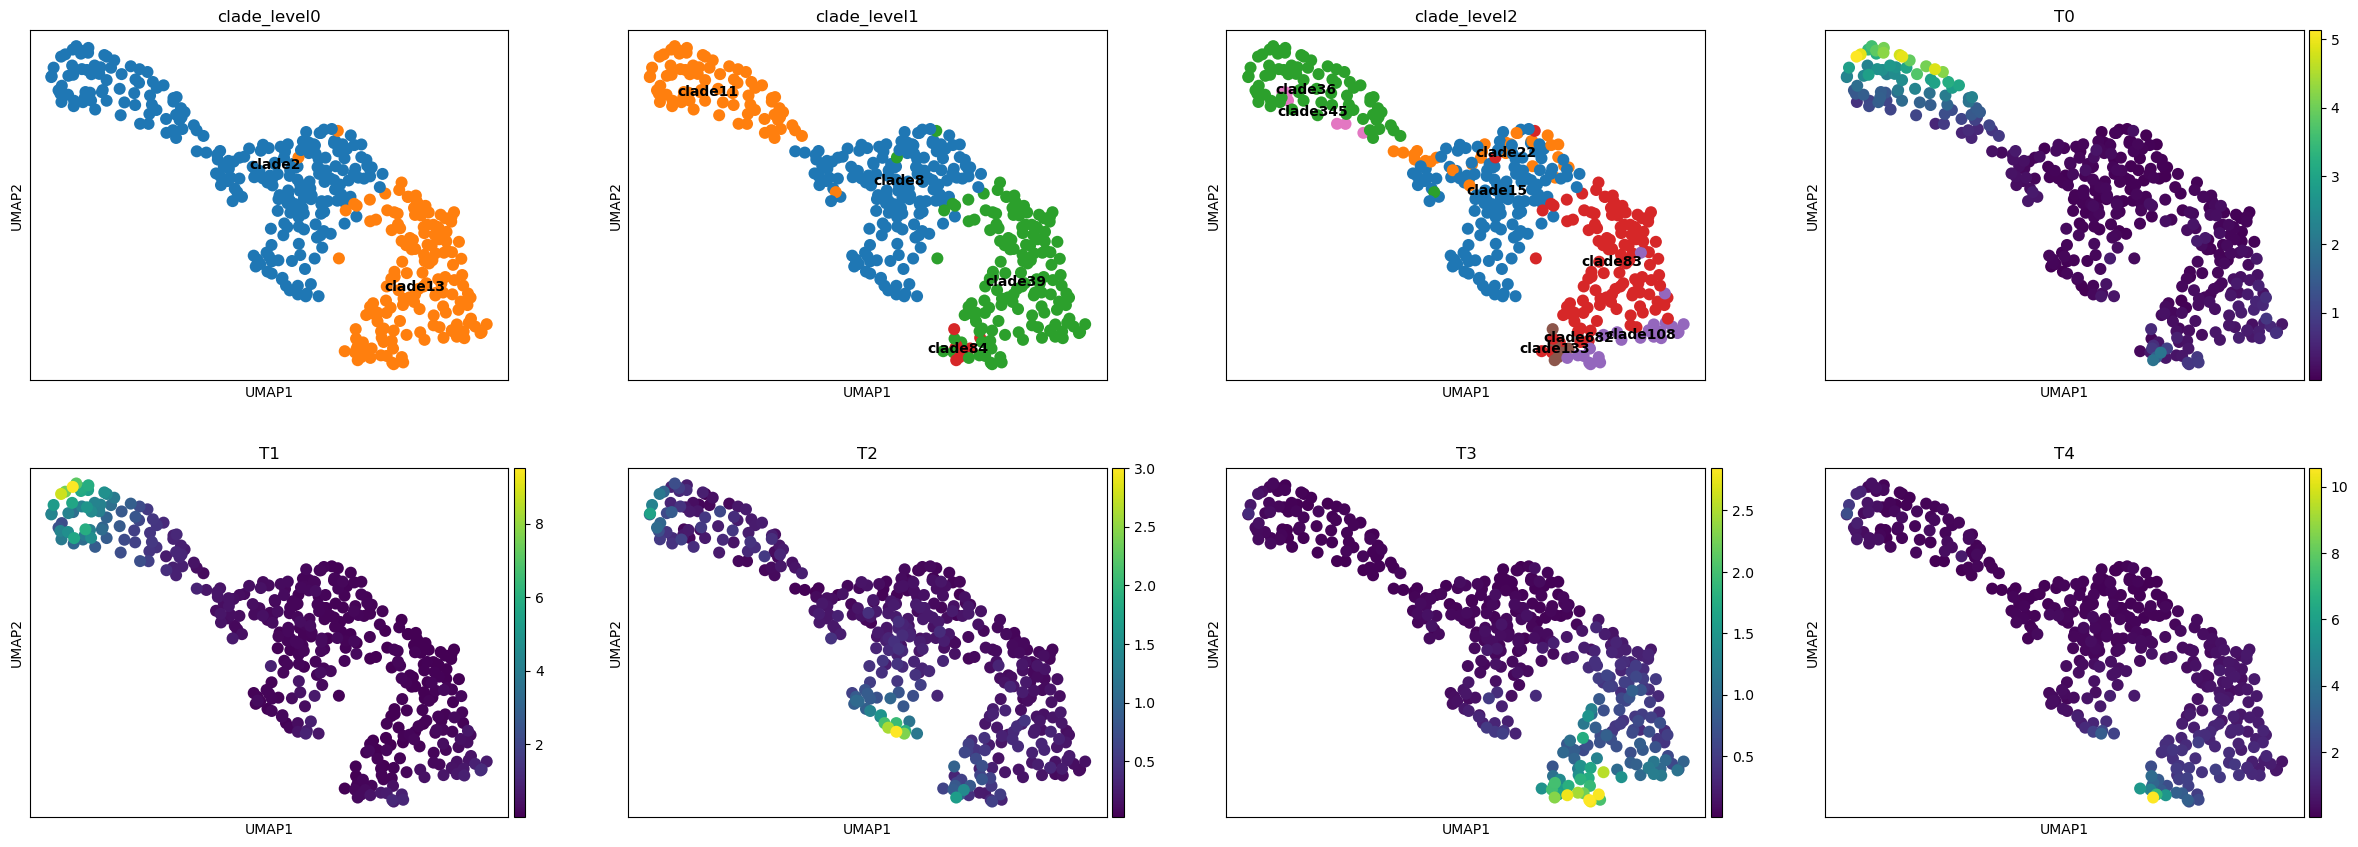

In [476]:
# Show clade in UMAP
import scanpy as sc
sc.pp.log1p(ss_simulated_adata)
sc.pp.pca(ss_simulated_adata)
sc.pp.neighbors(ss_simulated_adata)
sc.tl.umap(ss_simulated_adata)
sc.pl.umap(ss_simulated_adata, color=['clade_level0', 'clade_level1', 'clade_level2'] + ex_simulator.trait_names, legend_loc='on data')

## Spatial transcriptomics data simulation

In [461]:
gx, gy = visium_simulator.map_points_to_grid_lowerleft(
    x, y,
    xmin=0.0, ymin=0.0, 
    dx=.05, dy=0.05
)

In [462]:
cell_spot_locations = np.c_[gx, gy]
spots = np.unique(cell_spot_locations, axis=0)
# Make a vector of cell to spot names indicating which spot each cell belongs to
# For each cell, find the index of its spot in the unique spots array, then assign the corresponding spot name
cells_to_spots = np.array([
    f'spot_{np.where((spots == loc).all(axis=1))[0][0]}' for loc in cell_spot_locations
])


In [472]:
# Simulate spatial gene expression data
n_spots = spots.shape[0]
spot_expression = np.zeros((n_spots, n_genes))
spot_trait_activations = np.zeros((n_spots, n_traits))
spot_names = [f'spot_{i}' for i in range(n_spots)]
cells_in_spots = []
clades_fractions = []
clades_assignments = []
for spot in range(n_spots):
    spot_cells = np.where(cells_to_spots == f'spot_{spot}')[0]
    spot_expression[spot] = np.mean(expression.iloc[spot_cells], axis=0) # all transcripts
    spot_trait_activations[spot] = np.mean(trait_activations.iloc[spot_cells], axis=0) # all traits
    cells_in_spots.append(expression.iloc[spot_cells].index)
    clades_fractions.append(ss_simulated_adata.obs.loc[expression.iloc[spot_cells].index, 'clade_level2'].value_counts()/len(spot_cells))
    clades_assignments.append(ss_simulated_adata.obs.loc[expression.iloc[spot_cells].index, 'clade_level2'].value_counts().idxmax())
spatial_spot_library_sizes = np.random.poisson(1000, size=n_spots) * 0 + 1
spatial_spot_gene_sizes = np.random.poisson(100, size=n_genes) * 0 + 1
spatial_transcriptomes = np.random.normal(spot_expression, .01)#np.random.poisson(np.exp(spot_expression) * spatial_spot_library_sizes[:, None] * spatial_spot_gene_sizes[None, :])
spatial_simulated_adata = anndata.AnnData(pd.DataFrame(spatial_transcriptomes, index=spot_names, columns=ex_simulator.gene_names))
spatial_simulated_adata.obsm['spatial'] = spots
spatial_simulated_adata.obs['clade_level2'] = clades_assignments
spot_trait_activations = pd.DataFrame(spot_trait_activations, index=spot_names, columns=ex_simulator.trait_names)
for trait in ex_simulator.trait_names:
    spatial_simulated_adata.obs[trait] = np.exp(spot_trait_activations[trait])

/var/folders/d4/tfj5y66n2zzddb2k40xhyhk80000gp/T/ipykernel_49752/1210994467.py:2: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(spatial_simulated_adata, color=ex_simulator.trait_names + ['clade_level2'] + ex_simulator.gene_names, spot_size=.05)


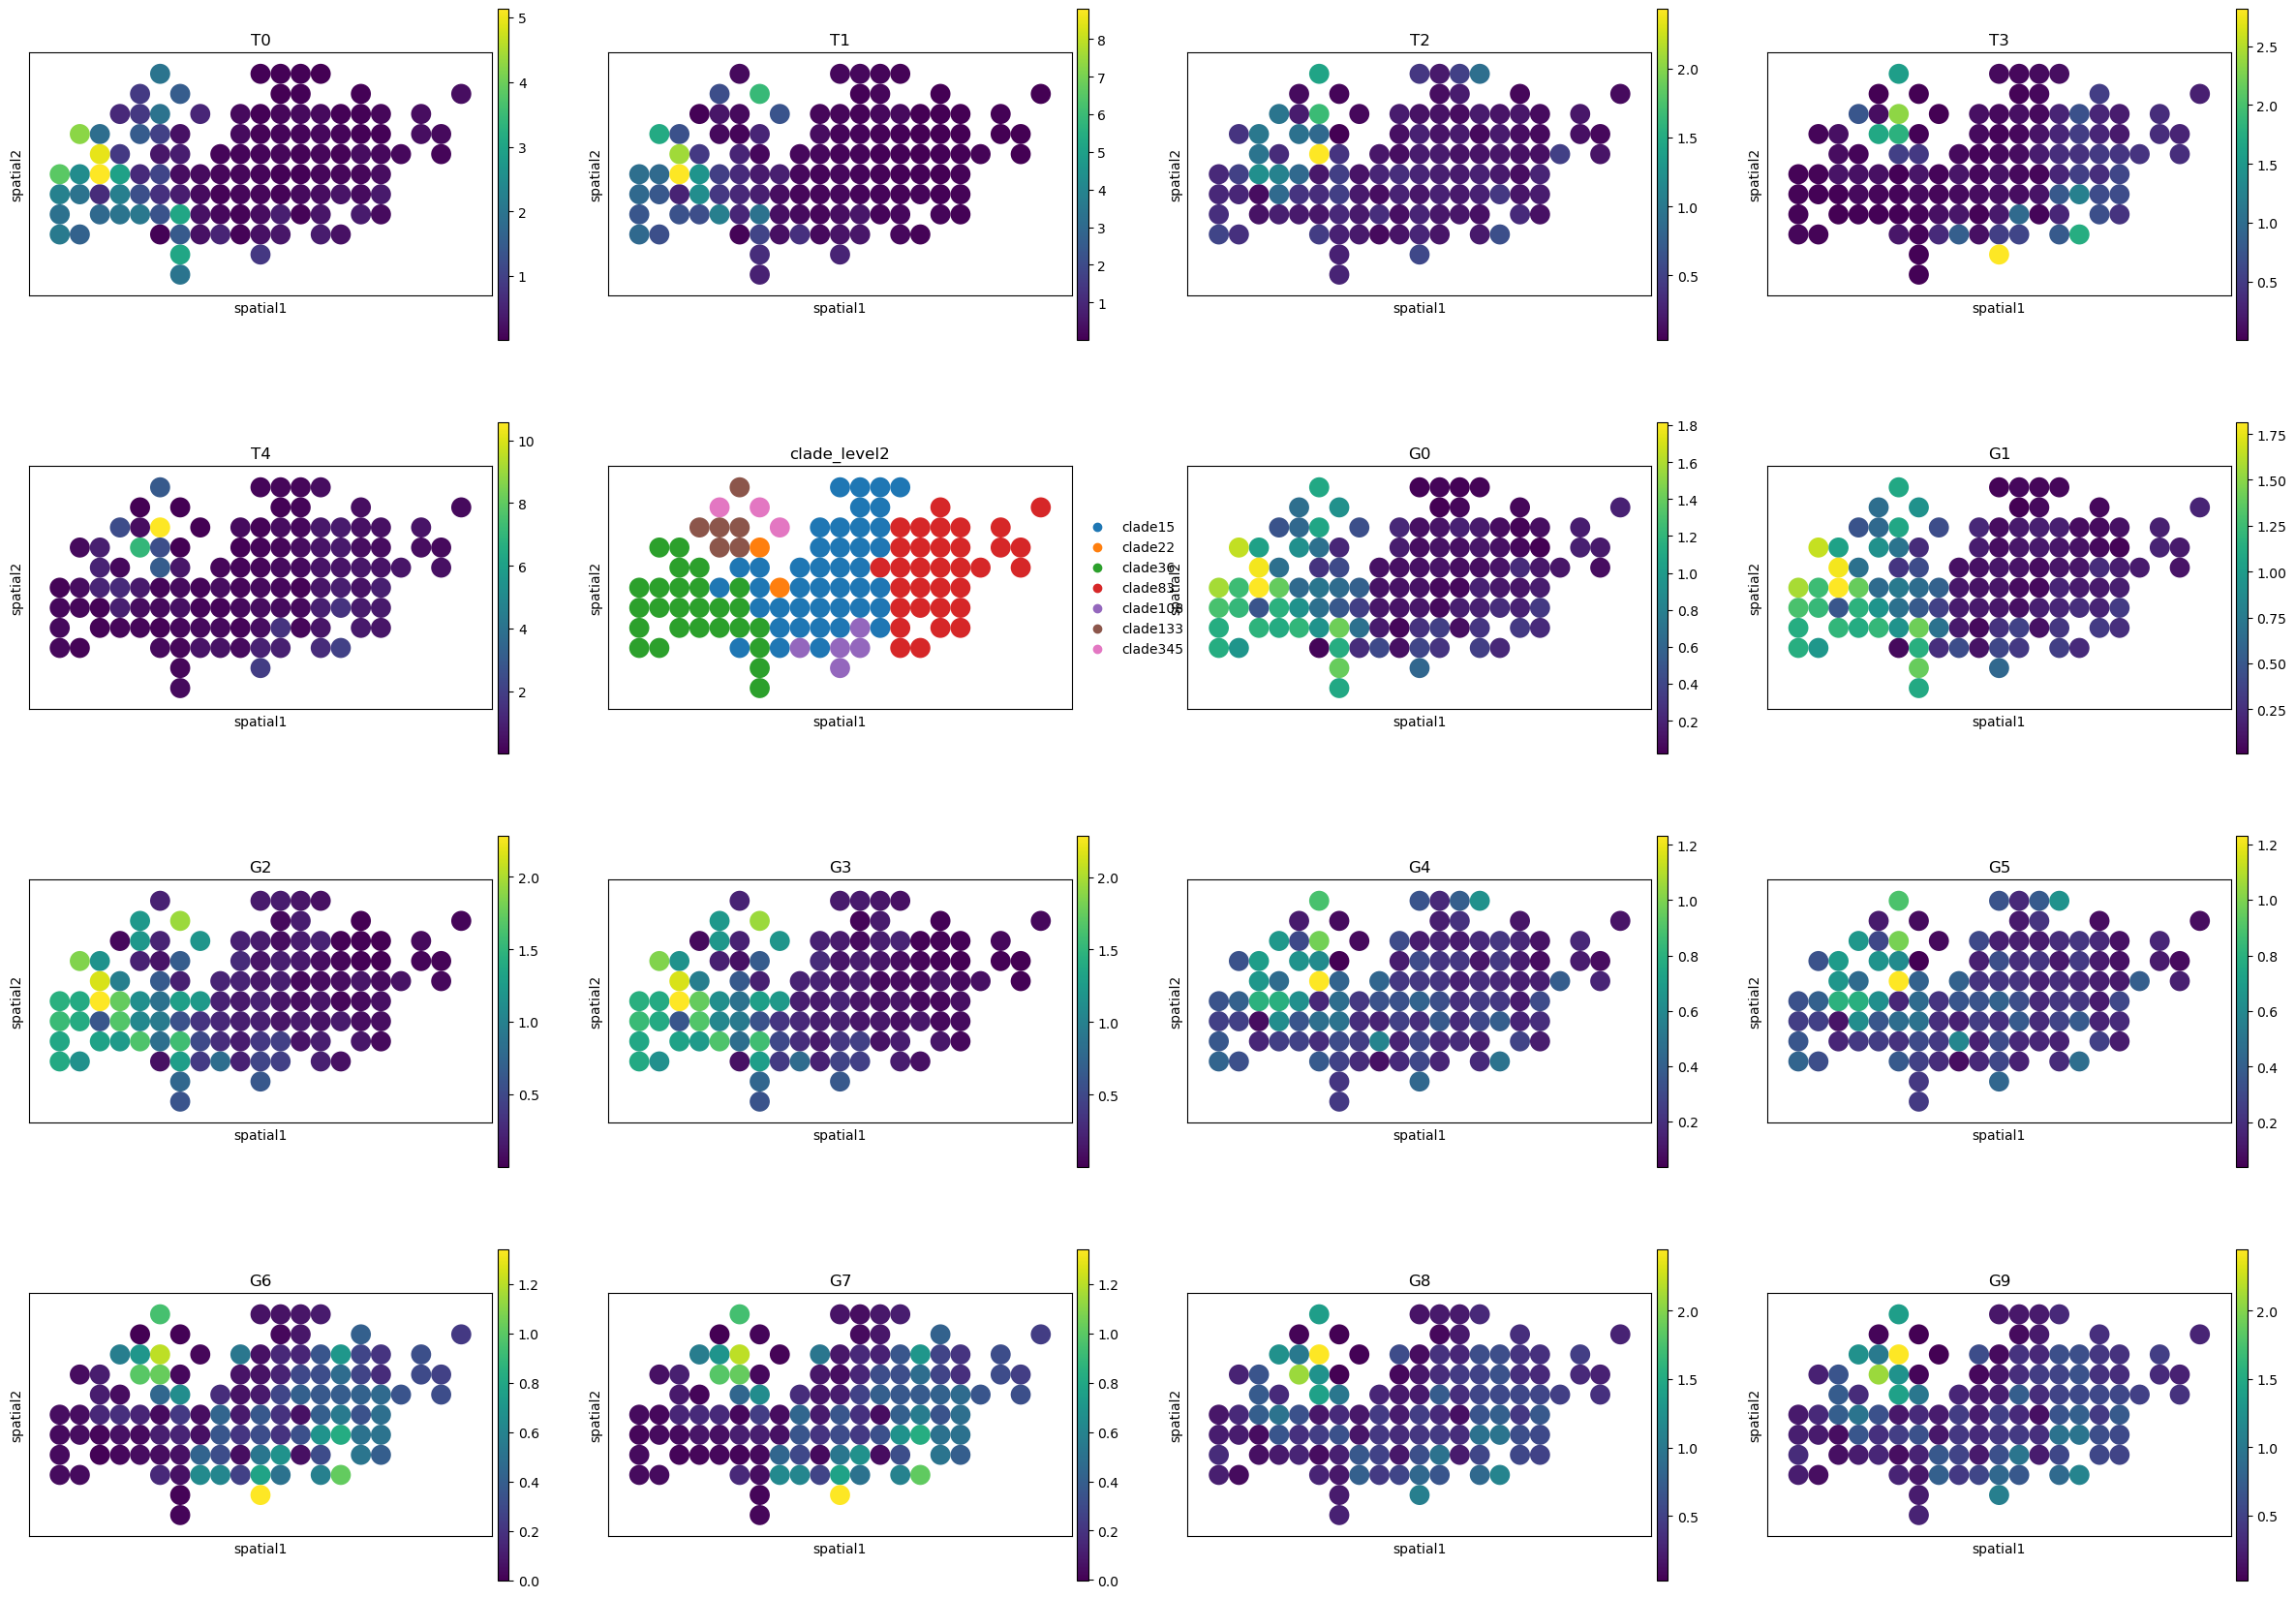

In [493]:
# Look at the spatial data
sc.pl.spatial(spatial_simulated_adata, color=ex_simulator.trait_names + ['clade_level2'] + ex_simulator.gene_names, spot_size=.05)

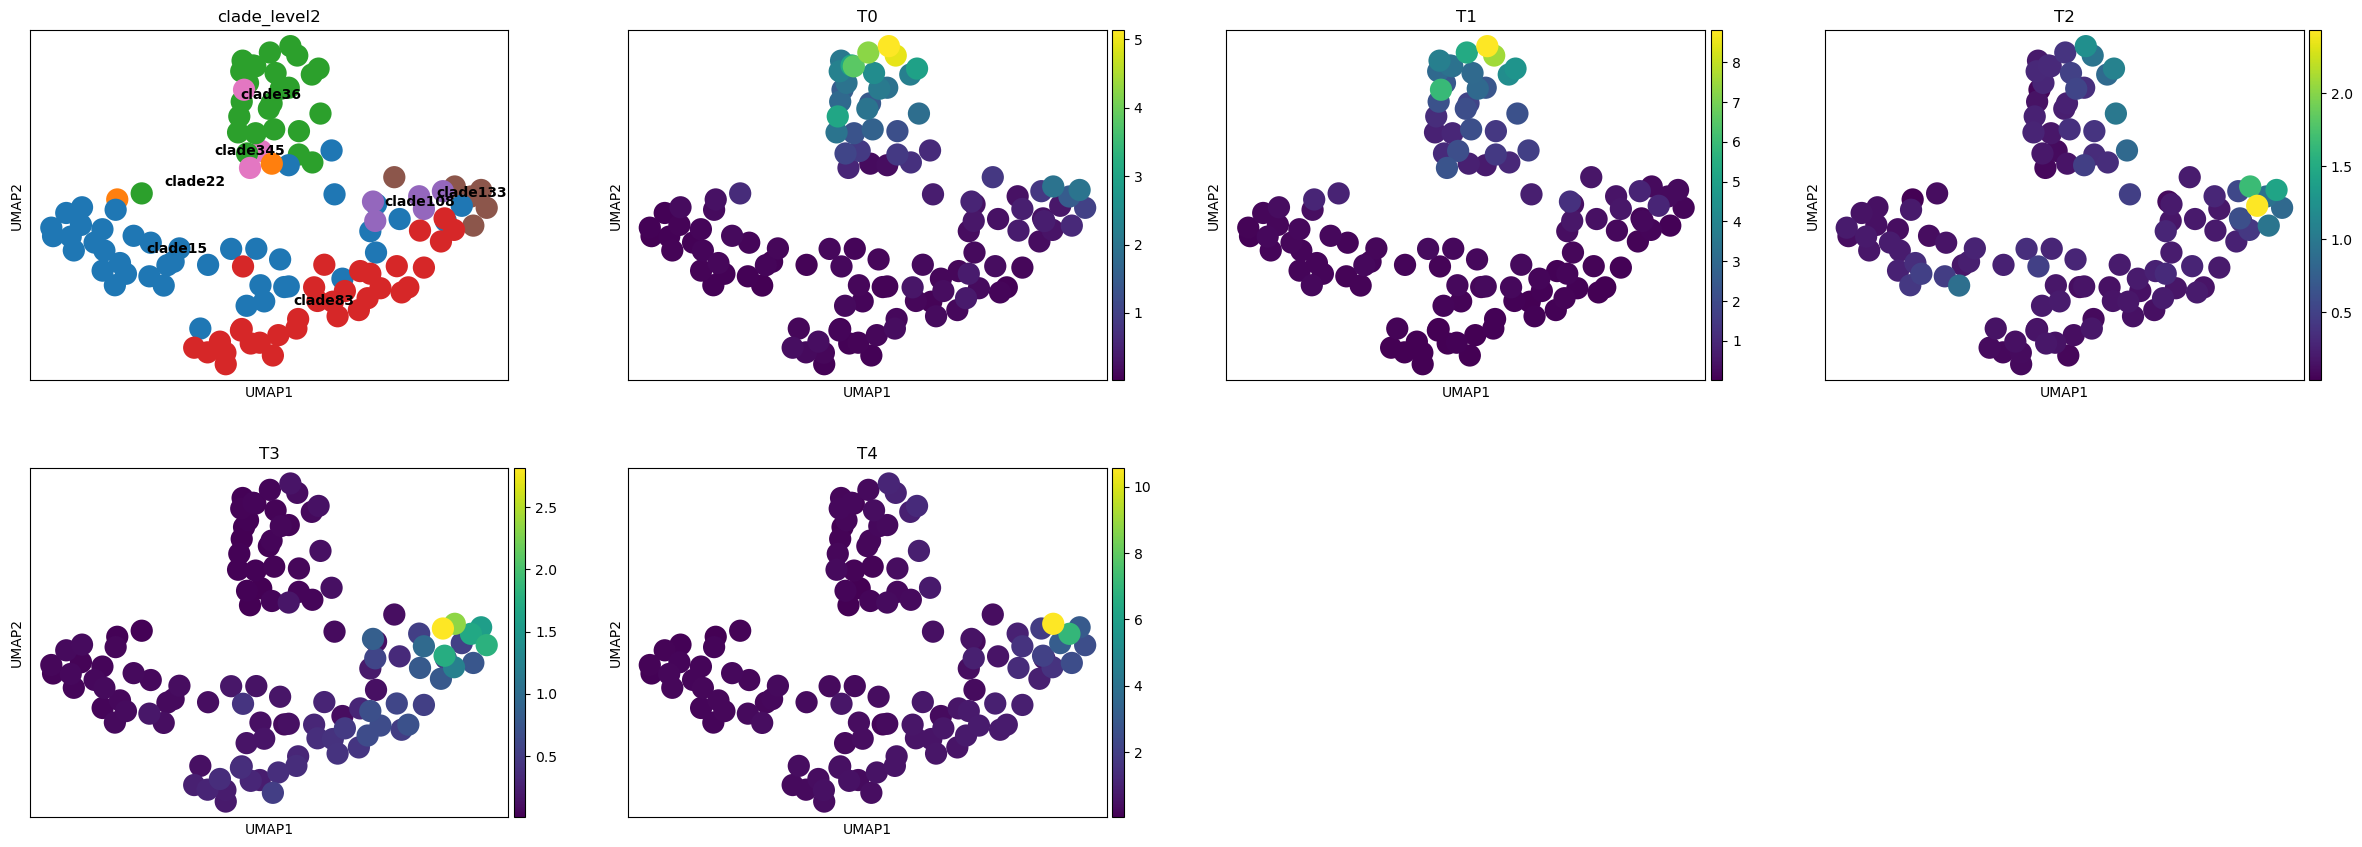

In [475]:
# Show clade in UMAP
import scanpy as sc
sc.pp.log1p(spatial_simulated_adata)
sc.pp.pca(spatial_simulated_adata)
sc.pp.neighbors(spatial_simulated_adata)
sc.tl.umap(spatial_simulated_adata)
sc.pl.umap(spatial_simulated_adata, color=['clade_level2'] + ex_simulator.trait_names, legend_loc='on data')

## Map the single-cell data to the spatial data

In [477]:
# Get distance matrices
tree_distance_matrix = cas.data.compute_phylogenetic_weight_matrix(simulated_tree)
spatial_distance_matrix = squareform(pdist(spots, metric='euclidean'))

### Correlation-based

In [478]:
# Assign each cell to the spot with the highest correlation
coupling = mappers.pairwise_correlations(np.asarray(ss_transcriptomes), np.asarray(spatial_transcriptomes))
correlation_assignments = np.argmax(coupling, axis=1)
correlation_assignments = spatial_simulated_adata.obs.index[correlation_assignments]

# Compute accuracy: fraction of correctly assigned cells
assignment_accuracy = np.mean(correlation_assignments == cells_to_spots)
print(f"Assignment accuracy: {assignment_accuracy:.3f}")


Assignment accuracy: 0.113


In [479]:
# build sets of true cells per spot
S = {f'spot_{j}': np.where(cells_to_spots == f'spot_{j}')[0] for j in range(n_spots)}

# per-cell distance to assigned spot (min to that spot’s true cells)
delta = np.array([
    tree_distance_matrix.values[i, S[correlation_assignments[i]]].min()
    for i in range(correlation_assignments.shape[0])
])

mean_tree_dist = delta.mean()
mean_tree_dist

np.float64(13.220866383980502)

/var/folders/d4/tfj5y66n2zzddb2k40xhyhk80000gp/T/ipykernel_49752/228068321.py:9: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(spatial_simulated_adata, color=['clade_level2', 'inferred_clade_level2'], spot_size=.05)


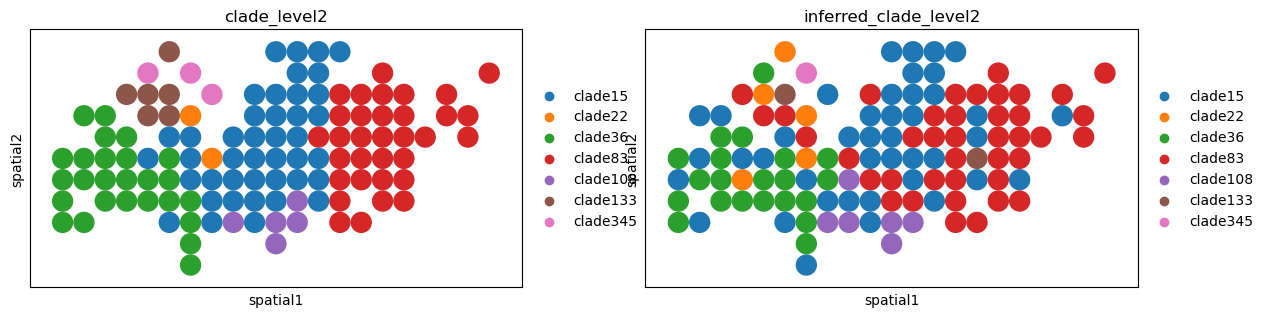

In [480]:
inferred_clades_assignments = []
for spot in range(n_spots):
    spot_cells = np.where(correlation_assignments == f'spot_{spot}')[0]
    inferred_clades_assignments.append(ss_simulated_adata.obs.loc[expression.iloc[spot_cells].index, 'clade_level2'].value_counts().idxmax())
spatial_simulated_adata.obs['inferred_clade_level2'] = inferred_clades_assignments

# Color the spatial data by the clade of the inferred cells assigned to each spot
spatial_simulated_adata.obs['inferred_clade_level2'] = inferred_clades_assignments
sc.pl.spatial(spatial_simulated_adata, color=['clade_level2', 'inferred_clade_level2'], spot_size=.05)

### Optimal transport on expression only

In [524]:
coupling = mappers.wot(np.asarray(ss_transcriptomes), np.asarray(spatial_transcriptomes))
w_assignments = np.argmax(coupling, axis=1)
w_assignments = spatial_simulated_adata.obs.index[w_assignments]

# Compute accuracy: fraction of correctly assigned cells
assignment_accuracy = np.mean(w_assignments == cells_to_spots)
print(f"Assignment accuracy: {assignment_accuracy:.3f}")

Assignment accuracy: 0.065


In [525]:
# build sets of true cells per spot
S = {f'spot_{j}': np.where(cells_to_spots == f'spot_{j}')[0] for j in range(n_spots)}

# per-cell distance to assigned spot (min to that spot’s true cells)
delta = np.array([
    tree_distance_matrix.values[i, S[w_assignments[i]]].min()
    for i in range(w_assignments.shape[0])
])

mean_tree_dist = delta.mean()
mean_tree_dist

np.float64(14.991404256686476)

/var/folders/d4/tfj5y66n2zzddb2k40xhyhk80000gp/T/ipykernel_49752/3470553198.py:9: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(spatial_simulated_adata, color=['clade_level2', 'inferred_clade_level2'], spot_size=.05)


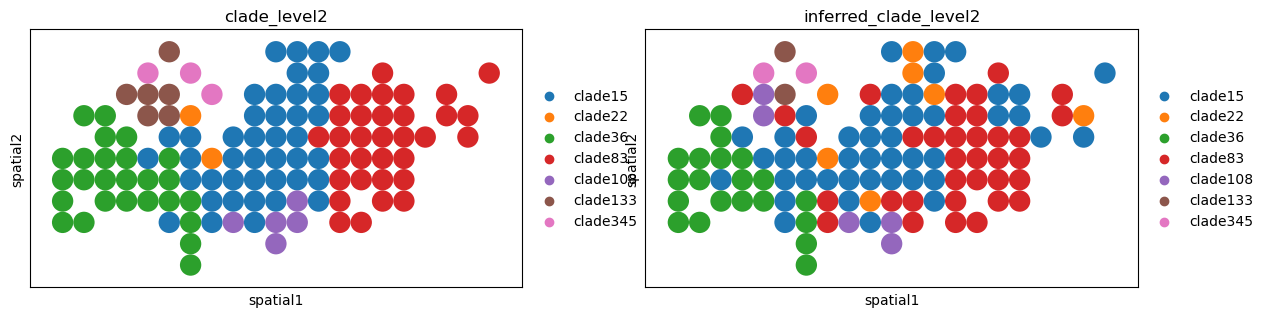

In [526]:
inferred_clades_assignments = []
for spot in range(n_spots):
    spot_cells = np.where(w_assignments == f'spot_{spot}')[0]
    inferred_clades_assignments.append(ss_simulated_adata.obs.loc[expression.iloc[spot_cells].index, 'clade_level2'].value_counts().idxmax())
spatial_simulated_adata.obs['inferred_clade_level2'] = inferred_clades_assignments

# Color the spatial data by the clade of the inferred cells assigned to each spot
spatial_simulated_adata.obs['inferred_clade_level2'] = inferred_clades_assignments
sc.pl.spatial(spatial_simulated_adata, color=['clade_level2', 'inferred_clade_level2'], spot_size=.05)


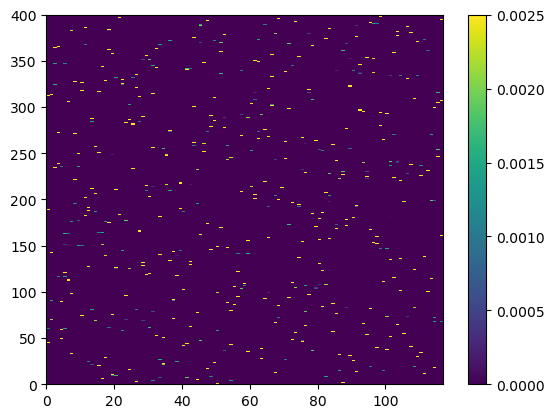

In [529]:
plt.pcolormesh(coupling)
plt.colorbar()
plt.show()

/Users/pedroferreira/miniconda3/envs/phylospatial/lib/python3.10/site-packages/ot/bregman/_sinkhorn.py:902: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


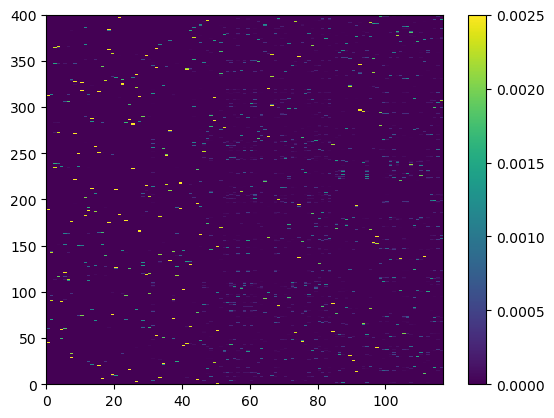

### Gromov-Wasserstein OT on tree and space only

In [485]:
coupling = mappers.gwot(np.asarray(tree_distance_matrix), np.asarray(spatial_distance_matrix))
gw_assignments = np.argmax(coupling, axis=1)
gw_assignments = spatial_simulated_adata.obs.index[gw_assignments]

# Compute accuracy: fraction of correctly assigned cells
assignment_accuracy = np.mean(gw_assignments == cells_to_spots)
print(f"Assignment accuracy: {assignment_accuracy:.3f}")

Assignment accuracy: 0.007


In [486]:
# per-cell distance to assigned spot (min to that spot’s true cells)
delta = np.array([
    tree_distance_matrix.values[i, S[gw_assignments[i]]].min()
    for i in range(gw_assignments.shape[0])
])

mean_tree_dist = delta.mean()
mean_tree_dist

np.float64(21.266943904366702)

/var/folders/d4/tfj5y66n2zzddb2k40xhyhk80000gp/T/ipykernel_49752/57552071.py:9: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(spatial_simulated_adata, color=['clade_level2', 'inferred_clade_level2'], spot_size=.05)


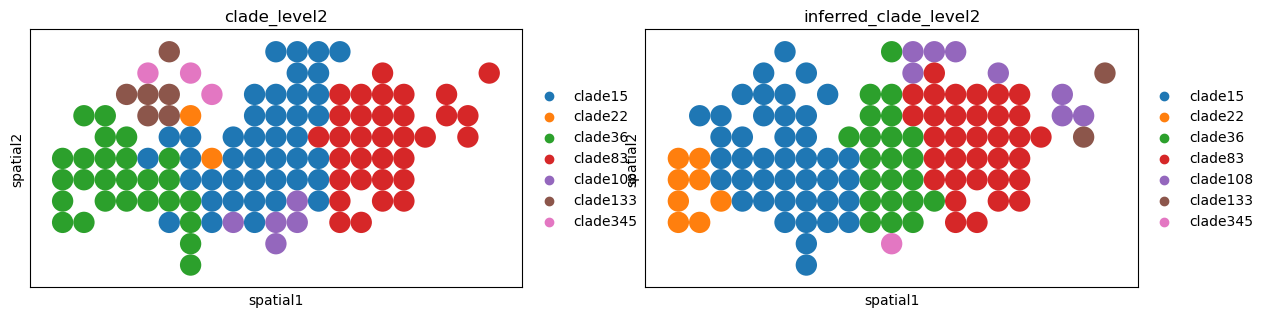

In [487]:
inferred_clades_assignments = []
for spot in range(n_spots):
    spot_cells = np.where(gw_assignments == f'spot_{spot}')[0]
    inferred_clades_assignments.append(ss_simulated_adata.obs.loc[expression.iloc[spot_cells].index, 'clade_level2'].value_counts().idxmax())
spatial_simulated_adata.obs['inferred_clade_level2'] = inferred_clades_assignments

# Color the spatial data by the clade of the inferred cells assigned to each spot
spatial_simulated_adata.obs['inferred_clade_level2'] = inferred_clades_assignments
sc.pl.spatial(spatial_simulated_adata, color=['clade_level2', 'inferred_clade_level2'], spot_size=.05)

### Fused Gromov-Wasserstein OT

In [491]:
coupling = mappers.fgwot(np.asarray(ss_transcriptomes), np.asarray(spatial_transcriptomes), np.asarray(tree_distance_matrix), np.asarray(spatial_distance_matrix), alpha=.5)
fgw_assignments = np.argmax(coupling, axis=1)
fgw_assignments = spatial_simulated_adata.obs.index[fgw_assignments]

# Compute accuracy: fraction of correctly assigned cells
assignment_accuracy = np.mean(fgw_assignments == cells_to_spots)
print(f"Assignment accuracy: {assignment_accuracy:.3f}")

Assignment accuracy: 0.065


/var/folders/d4/tfj5y66n2zzddb2k40xhyhk80000gp/T/ipykernel_49752/57552071.py:9: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(spatial_simulated_adata, color=['clade_level2', 'inferred_clade_level2'], spot_size=.05)


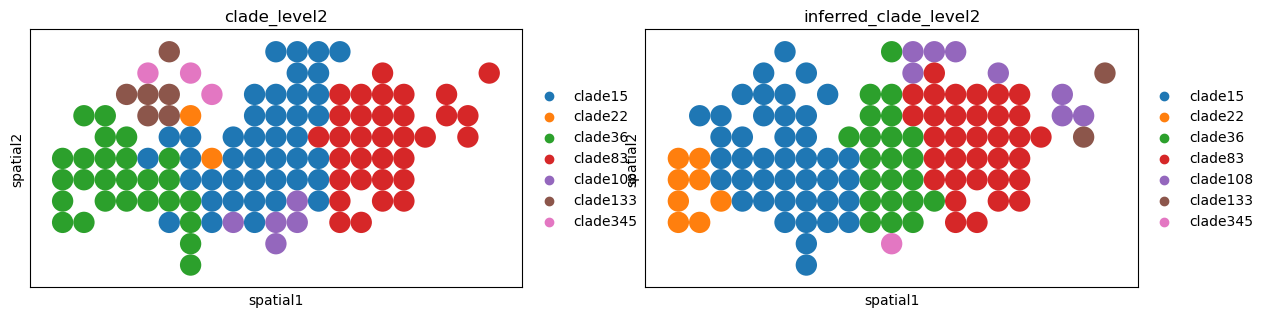

In [492]:
inferred_clades_assignments = []
for spot in range(n_spots):
    spot_cells = np.where(gw_assignments == f'spot_{spot}')[0]
    inferred_clades_assignments.append(ss_simulated_adata.obs.loc[expression.iloc[spot_cells].index, 'clade_level2'].value_counts().idxmax())
spatial_simulated_adata.obs['inferred_clade_level2'] = inferred_clades_assignments

# Color the spatial data by the clade of the inferred cells assigned to each spot
spatial_simulated_adata.obs['inferred_clade_level2'] = inferred_clades_assignments
sc.pl.spatial(spatial_simulated_adata, color=['clade_level2', 'inferred_clade_level2'], spot_size=.05)

In [494]:
# import matplotlib.pyplot as plt

# # Correlation-based assignment (first)
# corr_matrix = mappers.pairwise_correlations(np.asarray(ss_transcriptomes), np.asarray(spatial_transcriptomes))
# corr_assignments = np.argmax(corr_matrix, axis=1)
# corr_assignments = spatial_simulated_adata.obs.index[corr_assignments]
# corr_accuracy = np.mean(corr_assignments == cells_to_spots)

# # OT (expression only)
# ot_coupling = mappers.wot(np.asarray(ss_transcriptomes), np.asarray(spatial_transcriptomes))
# ot_assignments = np.argmax(ot_coupling, axis=1)
# ot_assignments = spatial_simulated_adata.obs.index[ot_assignments]
# ot_accuracy = np.mean(ot_assignments == cells_to_spots)

# # GW (tree+space only)
# gw_coupling = mappers.gwot(np.asarray(tree_distance_matrix), np.asarray(spatial_distance_matrix))
# gw_assignments = np.argmax(gw_coupling, axis=1)
# gw_assignments = spatial_simulated_adata.obs.index[gw_assignments]
# gw_accuracy = np.mean(gw_assignments == cells_to_spots)

# # FGW for different alpha values
# fgw_accuracies = {}
# for alpha in [0.1, 0.5, 0.9]:
#     fgw_coupling = mappers.fgwot(
#         np.asarray(ss_transcriptomes),
#         np.asarray(spatial_transcriptomes),
#         np.asarray(tree_distance_matrix),
#         np.asarray(spatial_distance_matrix),
#         alpha=alpha,
#     )
#     fgw_assignments = np.argmax(fgw_coupling, axis=1)
#     fgw_assignments = spatial_simulated_adata.obs.index[fgw_assignments]
#     fgw_accuracy = np.mean(fgw_assignments == cells_to_spots)
#     fgw_accuracies[f"FGW (alpha={alpha})"] = fgw_accuracy

# # Collect accuracies
# accuracies = {
#     "Correlation (expression only)": corr_accuracy,
#     "OT (expression only)": ot_accuracy,
#     "GW (tree+space only)": gw_accuracy,
# }
# accuracies.update(fgw_accuracies)

# # Plot
# plt.figure(figsize=(7, 4), dpi=200)
# bar_colors = ["#8172B3", "#4C72B0", "#55A868", "#C44E52", "#E17C05", "#B07AA1"][:len(accuracies)]
# plt.bar(accuracies.keys(), accuracies.values(), color=bar_colors)
# plt.ylabel("Assignment Accuracy")
# plt.ylim(0, 1)
# plt.title("Assignment Accuracy by Method")
# plt.xticks(rotation=20)
# plt.show()


### Joint FGW and alpha learning through deconvolution (ours) 

In [591]:
file_path = os.path.join(os.getcwd(), "../src/", "spotr.py")
spec = importlib.util.spec_from_file_location("spotr", file_path)
spotr = importlib.util.module_from_spec(spec)
spec.loader.exec_module(spotr)

In [592]:
import jax.numpy as jnp
import ot
a = jnp.ones(ss_transcriptomes.shape[0]) / ss_transcriptomes.shape[0]
b = jnp.ones(spatial_transcriptomes.shape[0]) / spatial_transcriptomes.shape[0]
X = jnp.asarray(ss_transcriptomes)
Y = jnp.asarray(spatial_transcriptomes)
C_tree = jnp.asarray(tree_distance_matrix)
C_space = jnp.asarray(spatial_distance_matrix)
C_feature = jnp.array(ot.dist(np.array(X), np.array(Y)))
K = 5
#cell_type_assignments = jnp.ones((X.shape[0], K))
cell_type_assignments = jnp.array(jnp.exp(trait_activations.values)) / jnp.sum(jnp.exp(trait_activations.values), axis=1, keepdims=True)
#cell_type_signatures = jnp.ones((K, Y.shape[1]))
cell_type_signatures = jnp.array(ex_simulator.trait_signatures.values)
sigma = .1
alpha, alpha_hist, loss_hist, coupling = spotr.learn_alpha_gamma(C_feature, Y, C_tree, C_space, a, b,
                                    cell_type_assignments, cell_type_signatures, sigma,
                                    eps=0.05, T_sinkhorn=5, J_alt=3,  K_outer=20, lr=1e-2, beta0=0.0, gamma0=None, uv0=None)
spotr_assignments = np.argmax(coupling, axis=1)
spotr_assignments = spatial_simulated_adata.obs.index[spotr_assignments]

# Compute accuracy: fraction of correctly assigned cells
assignment_accuracy = np.mean(spotr_assignments == cells_to_spots)
print(f"Assignment accuracy: {assignment_accuracy:.3f}")

100%|██████████| 20/20 [00:00<00:00, 32.36it/s, loss=-1.79e+4]

Assignment accuracy: 0.005


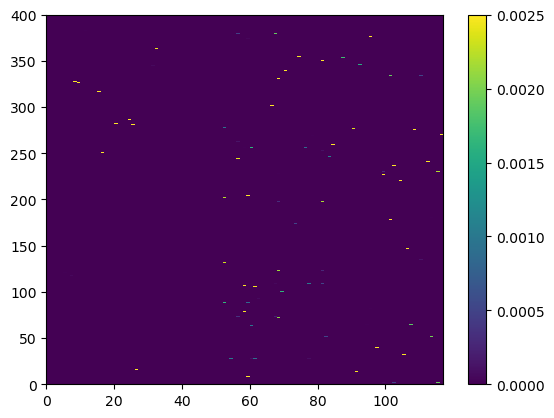

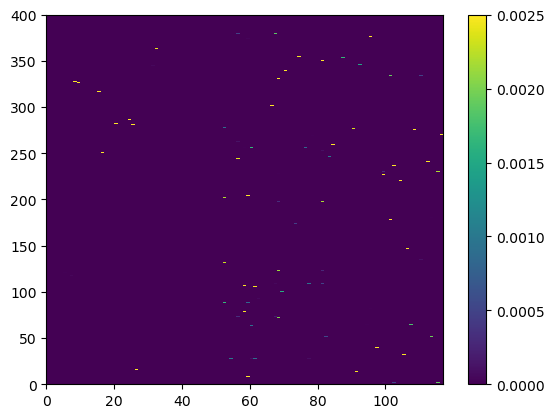

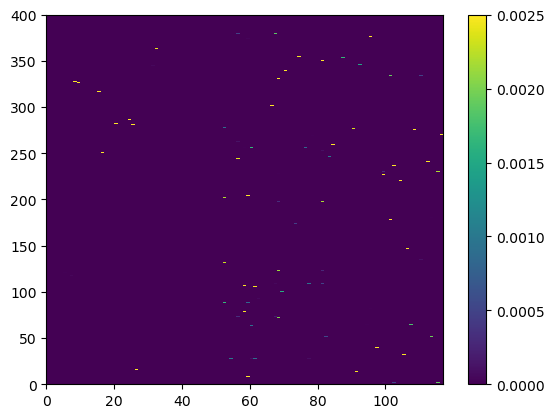

In [ ]:
# There's some re-scaling issue with build_fgw_cost that doesn't appear in POT's implementation

gamma_star = gamma0
uv_star = uv0
for i in range(3):
    C = spotr.build_fgw_cost(0.00001, C_feature, C_tree, C_space, a, b, gamma_star)
    gamma_star, uv_star = spotr.sinkhorn_unrolled(C, a, b, 0.001, 500, uv_star)
    plt.pcolormesh(gamma_star)
    plt.colorbar()
    plt.show()

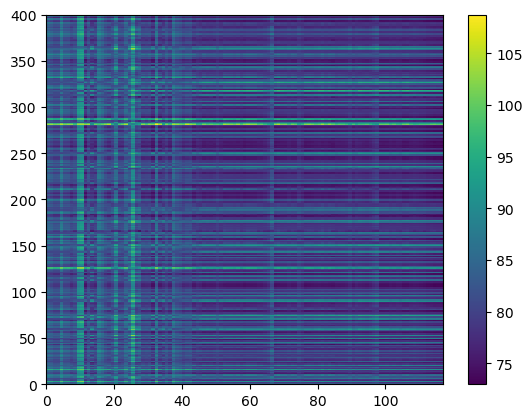

In [604]:
C = spotr.build_fgw_cost(0.1, C_feature, C_tree, C_space, a, b, gamma0)
plt.pcolormesh(C)
plt.colorbar()
plt.show()

In [532]:
# Check that the deconvolution loss is low when the couplings are good
spotr.deconvolution_loss(Y, coupling, cell_type_assignments, cell_type_signatures, 1.)

Array(-1268.8245, dtype=float32)

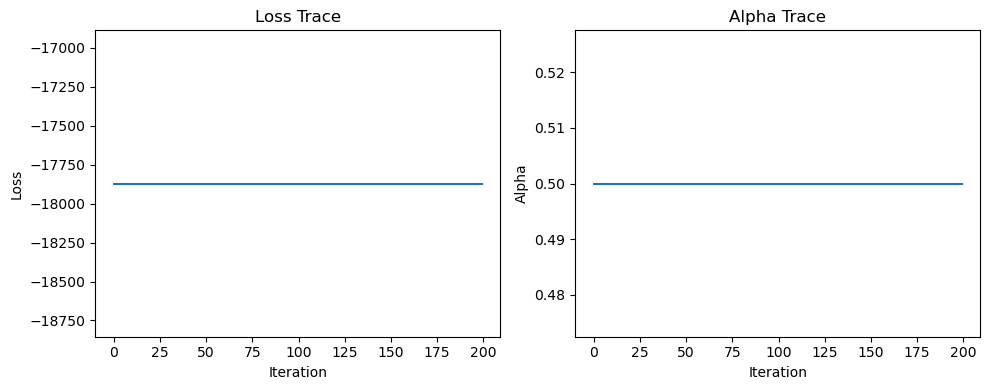

In [521]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Plot loss trace
axs[0].plot(loss_hist)
axs[0].set_title("Loss Trace")
axs[0].set_xlabel("Iteration")
axs[0].set_ylabel("Loss")

# Plot alpha trace
axs[1].plot(alpha_hist)
axs[1].set_title("Alpha Trace")
axs[1].set_xlabel("Iteration")
axs[1].set_ylabel("Alpha")

plt.tight_layout()
plt.show()


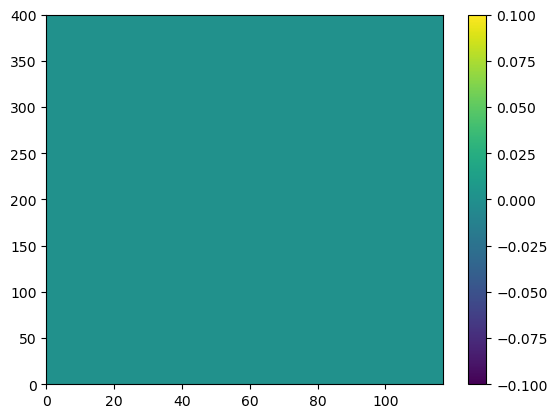

In [501]:
plt.pcolormesh(coupling)
plt.colorbar()
plt.show()

### Joint FGW and per-clade alpha learning through deconvolution (ours)